# Tarea 2
## Laboratorio de Datos

In [3]:
# librerías usadas
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
#Estas lineas corren solo en google colab:
import os.path 
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  if os.path.exists('/content/ChestXRay2017.zip'):
    print("Datos ya descargados")
  else:
    !wget https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip
    !unzip /content/ChestXRay2017.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: chest_xray/train/PNEUMONIA/person802_bacteria_2708.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person902_bacteria_2827.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person825_bacteria_2736.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1733_bacteria_4566.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person28_bacteria_141.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person494_bacteria_2090.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1088_virus_1800.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person62_bacteria_300.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1328_virus_2295.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1109_bacteria_3050.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person554_bacteria_2320.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person573_bacteria_2369.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1597_bacteria_4192.jpeg  
  inflating: chest_xr

# 1 Carga y transformación de Datos

In [14]:
# 1
# iniciar datos
def load(path):
    image_rgb =Image.open(path).convert("RGB")
    return image_rgb

div= np.iinfo('uint8').max # maximo valor de tipo uint8
transformers=transforms.Compose(
                [transforms.Resize([224,224]),
                 transforms.RandomRotation(degrees=20),
                 transforms.RandomHorizontalFlip(),
                 transforms.ColorJitter(brightness=[1.2, 1.5]),
                 transforms.ToTensor()
                ])

# Usamos el loader por defecto de ImageFolder
# Deja las imagenes con 3 capas
from torchvision.datasets.folder import default_loader
    
data_train1=datasets.DatasetFolder(root='chest_xray/train',loader=default_loader,transform=transformers, extensions='jpeg')
data_test1=datasets.DatasetFolder(root='chest_xray/test',loader=default_loader,transform=transformers, extensions='jpeg')

In [57]:
import skimage.transform 
#### PERFILmiento 
#### seleccionamos skimage y pytorch 
### Primero probamos para una imagen random, el desempeño en timepo 
filename = '/content/drive/My Drive/dog.jpg'
input_image = Image.open(filename)

#### con pytorch 
input_tensor = transformers(input_image).float()

print('dimesioneso originales:',input_tensor.shape)

dimesioneso originales: torch.Size([3, 224, 224])


In [99]:
from skimage.transform import resize
from skimage.io import imread, imshow

### con skimage
imgen = imread('/content/drive/My Drive/dog.jpg')
def transforma(img):

 img_resized =skimage.transform.rotate(img,angle=20,resize=False, mode='constant')
 m=skimage.transform.resize(img_resized, [224,224])
 m = skimage.exposure.adjust_gamma(m, gamma=np.random.choice([1.2,1.5]),gain=1)

 return m

m=transforma(imgen)
print('dimesioneso resize:',m.shape)



dimesioneso resize: (224, 224, 3)


In [100]:
## comparacion 
%prun transforma(imgen)


In [101]:
%prun transformers(input_image).float()

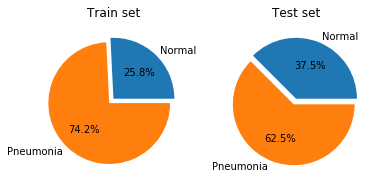

In [ ]:
# 2

classes_train1 = data_train1.targets
classes_test1 = data_test1.targets

pneumonia_train=int(sum(classes_train1))
normal_train=len(classes_train1)-pneumonia_train


pneumonia_test=int(sum(classes_test1))
normal_test=len(classes_test1)-pneumonia_test

labels = 'Normal', 'Pneumonia'
sizes_train = [normal_train, pneumonia_train]

sizes_test = [normal_test, pneumonia_test]

fig, axs = plt.subplots(1,2)
axs[0].pie(sizes_train,labels=labels,explode=(0,0.1),autopct='%1.1f%%')
axs[1].pie(sizes_test,labels=labels,explode =(0,0.1),autopct='%1.1f%%')

axs[0].set_title('Train set')
axs[1].set_title('Test set')

plt.show()

In [ ]:
# 3

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# split
train_idx, val_idx = train_test_split(list(range(len(data_train1))),test_size=0.2)
#data_train = Subset(data_train1, train_idx)
#data_val   = Subset(data_train1,val_idx)

class ReplicarMuestreoDePrueba(torch.utils.data.Sampler):
    
    def __init__(self,etiquetas_prueba, indices_val, etiquetas_val):
        self.indices_val      = indices_val
        #self.etiquetas_val    = etiquetas_val
        self.prob_pneumonia   = sum(etiquetas_val)/len(etiquetas_prueba)
        self.prob_normal      = 1-self.prob_pneumonia
        self.prob_vector      = [ int((etiquetas_val[i]==1 )*self.prob_pneumonia+
                                 (etiquetas_val[i]==0)*self.prob_normal)
                                for i in range(len(etiquetas_prueba))
                                ]
    def __iter__(self):
        return iter(np.random.choice(self.indices_val,p=self.prob_vector))
    
etiquetas_prueba = data_test1.targets
# indices_val = val_idx
etiquetas_val = [data_train1.targets[i] for i in val_idx ] 

a=ReplicarMuestreoDePrueba(etiquetas_prueba,val_idx, etiquetas_val)

In [ ]:
# 4
from torch.utils.data.sampler import RandomSampler, SubsetRandomSampler

data_train = DataLoader(data_train1,sampler=SubsetRandomSampler(train_idx))
data_val   = DataLoader(data_train1,sampler=ReplicarMuestreoDePrueba(etiquetas_prueba,val_idx, etiquetas_val))
data_test  = DataLoader(data_test1,sampler=RandomSampler(data_test1))

In [ ]:
data_train.dataset.

<function torchvision.datasets.folder.default_loader(path)>

In [ ]:
len(train_idx)

4185